# **Smart PAD Scheduler**

This notebook has been built to take an existing full field development and optimize the development sequence of the pads. It was born from an attempt to minimize the parent-child interactions (time gap) while honouring the development schedule hard constraints (e.g.: break-up season, water availability, start date, etc). Assessing the viability of a PADs sequence takes seconds instead of the traditional days. This significant time improvement allows running multiple iterations and it opens the door to identifying an optimal schedule.



---


It handles hard constraints like drilling and completion windows. Soft constraints are also tracked in order to identify optimized development sequences. 

---

This Jupyter notebook was built on the Google Colab platform and it's import and export functionalities are link to it.



##LIBRARIES: Import

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FuncFormatter, MaxNLocator, FormatStrFormatter
import matplotlib.dates as mdates
%matplotlib inline

import shapely.geometry
import shapely.affinity
from shapely.geometry import Polygon

from math import atan

!pip install descartes
from descartes import PolygonPatch

import datetime
from datetime import timedelta

from IPython.display import clear_output
import timeit

import warnings
warnings.filterwarnings("ignore")

#Local drive fetching
from google.colab import files
import io

# Code to read Google Drive file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

## INPUTS



**PAD Input (CSV)**


This input is used to assign some pad specific info to the wells and provide (x,y) coordinate for labels display. Only one line per pad is allowed. That being said, a pad can be subdivided into groups of wells as long as they a different "id" and "id_short" (i.e.: xxx_N and xxx_S)


Columns needed:

*   "id" -> a unique id for the pad
*   "id_short" -> a reduced character id that will be use for label display in map view and gant chart
*   "basin" -> the watershed the pad is located into
*   "x_mid" -> the x coordinate (preferably UTM Easting) to display the "id_short" in map view
*   "y_mid" -> the y coordinate (preferably UTM Northing) to display the "id_short" in map view
*   "drill_days" -> the number of days estimate to drill a given well on the pad.
*   "freehold_wells" -> the number of wells on the pad with Freehold status. This is subsequently used as a metrics to compare various runs.
*   "expiry" -> Date by which a given pad must be on production. This is also subsequently used as a metrics to compare various runs.




**WELL Input (CSV)**

This input is used to assign spatial attribute to the wells and subsequently create spatial representation of pads. One line per well is allowed.

Columns needed:
*  "well" -> a unique id assigned to the well.
*  "pad_id" -> an id that must match the "id" column within the PAD input. This is use to assign the wells back to the pad they belong to.
*  "toe_x" -> the spatial x coordinate of the well toe (preferably UTM Easting).
*  "toe_y" -> the spatial y coordinate of the well toe (preferably UTM Northing).
*  "heel_x" -> the spatial x coordinate of the well heel (preferably UTM Easting).
*  "heel_y" -> the spatial y coordinate of the well heel (preferably UTM Northing).
*  "heel_md" & "toe_md" -> These 2 metrics are used to calculate the lateral length of the stick.


**DRILLED Wells Input (CSV)**

This input is used for visually displaying existing wells. Multiple lines (survey stations) can be given per well. 

Columns needed:
*  "x" -> Preferably UTM Easting
*  "y"  -> Preferably UTM Northing
*  "uwi" -> a unique id used to aggregate the multiple lines (survey stations)

**FILE IMPORT: From Local Desktop**

In [0]:
# Fetch PAD Input (CSV)
pad_upload = files.upload()

Saving Dataset_Pad.csv to Dataset_Pad (1).csv


In [0]:
#Fetch WELL Input (CSV)
well_upload = files.upload()

Saving Dataset_Wells.csv to Dataset_Wells (5).csv


In [0]:
#Fetch DRILLED Wells Input (CSV)
drilled_upload = files.upload()

Saving Dataset_Drilled.csv to Dataset_Drilled (1).csv


In [0]:
# Store PAD dataset under df_pad
df_pad = pd.read_csv(io.BytesIO(pad_upload['Dataset_Pad.csv']))

# Store WELL dataset under df_well
df_well = pd.read_csv(io.BytesIO(well_upload['Dataset_Wells.csv']))

# Store DRILLED dataset under df_drilled
df_drilled = pd.read_csv(io.BytesIO(drilled_upload['Dataset_Drilled.csv']))

**FILE IMPORT: From Google Drive**

In [0]:
#Mount Google Drive.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#Store dataset from Google Drive in a Pandas Dataframe
df_pad = pd.read_csv('gdrive/My Drive/Colab Notebooks/DataSets/Dataset_Pad.csv')
df_well = pd.read_csv('gdrive/My Drive/Colab Notebooks/DataSets/Dataset_Wells.csv')
df_drilled = pd.read_csv('gdrive/My Drive/Colab Notebooks/DataSets/Dataset_Drilled.csv')

##PARAMETERS: Customisation

In [0]:
#Development Start date
dev_start = datetime.date(2021, 1, 1) #year, month, day.

#Number of crews
n_rig = 2 #Drilling Rig
n_crew = 2 #Completion Crew

#Drilling BREAK_UP
bu_month_start, bu_day_start = 4, 1 #April 1st
bu_month_end, bu_day_end   = 6, 15 #June 15th

#Completion WINTER season
winter_month_start, winter_day_start = 12, 15 #December 15th
winter_month_end, winter_day_end   = 5, 31 #May 31st

#River Withdrawal Period
withdraw_month_start, withdraw_day_start = 4, 15 #April 15th
withdraw_month_end, withdraw_day_end   = 10, 31 #October 31st

#Completion Parameters
compl_day_lag = timedelta(days = 30) #Number of days before winter season that a completion crew can start operations
water_threshold = 0.8 #Fraction of total completion water needed available in pond before to start on a given pad. 
stage_per_day = 8 #Number of stages per day
stage_per_day_handicap = -1 #Reduction in stages per day (handicap) for first few pads to account for learning curve
stage_handicap_length = 2 #Number of pad before handicap goes away
compl_mob_demob = timedelta(days = 7) #Time added to completion for mobilizing and demobilizing the crew.
soak_time = timedelta(days = 30) #Days added to completion before pad is on-stream

#SIMOPS
well_spacing = 300 #Approximate distance between wells
width_incr_margin = 200 #Width added to the box perpendicular to the well (to generate overlapp with neighboor).
long_incr_margin = 300 #Length to add to the box in the direction of the well

#Basin/Pond Specs
basin_specs = {'basin': ['Red Deer', 'Clearwater'],
        'pond_capa': [950000, 950000], #Pond capacity (m3) 
        'pond_vol': [0, 0], #Volume at t0 (m3). 
        'max_withdraw_rate': [0.1, 0.1], #m3/s during withdrawal period
        'yearly_max': [2000000, 1800000], #Maximum yearly withdrawal allowance (m3)
        'yearly_vol': [0, 0]} #Volume already withdrawed at t0 (m3).

#Number of pad that do not get shuffle by the optimizer. These are the 'n' first of the schedule. Feature meant to capture the licensed or built pads.
index_shuffle = 5 

#Break-up length
bu_length = timedelta(days = round((bu_month_end - bu_month_start) * 30.5 + (bu_day_end - bu_day_start)))



##SPATIAL REPRESENTATION
Extract pad spatial information from the well Dataframe. Heel and toe coordinates are being used with SIMOPS parameters to create a 2D spatial representation of each pads.

In [0]:
#Create well entity (Shapely representation) and stored it in df_well
df_well['entity'] = 0
df_well['length'] = 0
df_well['azi'] = 0

for n, item in enumerate(df_well.well):
  heel_x = df_well.heel_x[n]
  heel_y = df_well.heel_y[n]
  toe_x = df_well.toe_x[n]
  toe_y = df_well.toe_y[n]
  cx = (heel_x + toe_x) / 2
  cy = (heel_y + toe_y) / 2
  length = df_well.toe_md[n] - df_well.heel_md[n]
  df_well['length'][n] = length #Store length in df_well
  angle = 90 - (57.2958 * atan((toe_y - heel_y) / (toe_x - heel_x)))
  df_well['azi'][n] = angle #Store azi in df_well
  w = well_spacing + width_incr_margin
  h = length + long_incr_margin
  c = shapely.geometry.box(-w/2.0, -h/2.0, w/2.0, h/2.0)
  rc = shapely.affinity.rotate(c, 180 - angle)
  shape = shapely.affinity.translate(rc, cx, cy)
  df_well['entity'][n] = shape
  
#Create pad entity (Shapely representation) and stored it in df_pad
df_pad['entity'] = "Undefined"
for n, item in enumerate(df_well.well): 
  pad_entity = df_pad[df_pad.id == df_well.pad_id[n]].entity.iloc[0]
  if pad_entity == "Undefined":
    pad_entity = df_well.entity[n] #Pad entity equal the fist well shape if 1st time we pull this pad
  else:
    pad_entity = pad_entity.union(df_well.entity[n]) #Pad entity equalt union if subsequent
  pad_index = df_pad[df_pad.id == df_well.pad_id[n]].index[0]
  df_pad.set_value(pad_index, 'entity', pad_entity) #df_pad is updated with latest entity

#Add len_tot, stage_tot and water_tot to df_pad
len_tot = df_well.groupby(['pad_id']).sum().length.rename('len_tot')
df_pad = pd.merge (df_pad, len_tot, left_on= ['id'], right_index=True)
df_pad['stage_tot'] = df_pad.len_tot.div(60).round(0)
df_pad['water_tot'] = df_pad.stage_tot.multiply(1500)

#Add n_wells to df_pad
n_wells = df_well.groupby(['pad_id']).count().well.rename('n_wells')
df_pad = pd.merge (df_pad, n_wells, left_on= ['id'], right_index=True)

#Add Azimuth to df_pad
azi = df_well.groupby(['pad_id']).mean().round(0).azi.rename('azi')
df_pad = pd.merge (df_pad, azi, left_on= ['id'], right_index=True)

##FUNCTIONS

In [0]:
def tracker_ini():
  """
  Instantiate the 5 tracking DataFrames that will be used in the main function and the scheduling section.
  """
  #Build the "Rig Tracking Dataframe"
  rig_tracker = pd.DataFrame(columns=['rig', 'status', 'drill_end'])
  for rig in range(0, n_rig):
    rig_tracker.loc[rig] = [rig, 'Free', 'NA']  

  #Build the "Crew Tracking Dataframe"
  crew_tracker = pd.DataFrame(columns=['crew', 'status', 'compl_end'])
  for crew in range(0, n_crew):
    crew_tracker.loc[crew] = [crew, 'Free', 'NA']  

  #Build the "Pad Tracking DataFrame"
  pad_tracker = pd.DataFrame(columns=['id', 'status', 'ops_end', 'drill_start', 'drill_end', 'compl_start', 'compl_end'])
  for n, pad in enumerate(df.id):
    pad_tracker.loc[n] = [pad, 'Undrilled', "NA", "NA", "NA", "NA", "NA"] 
    
  #Build the "Pond Tracking DataFrame"
  water_tracker = pd.DataFrame(basin_specs, columns =['basin', 'pond_capa', 'pond_vol', 'max_withdraw_rate', 'yearly_max', 'yearly_vol'])
  water_tracker.set_index(keys = 'basin', inplace = True)
  
  #Time Tracker
  time_tracker = pd.DataFrame(columns=['date', 'clearwater_pond', 'red_deer_pond'])
  
  return rig_tracker, crew_tracker, pad_tracker, water_tracker, time_tracker


# ---------------------------- TIME FUNCTIONS -------------------------


def in_between(date, period):
  """
  Take a Python date (yyyy, mm, dd) and return a boolean statement if it falls within the period (mm, dd). Can handle start being the year before (end_month < start_month).
  """
  #Assign month_start and month_end
  if period == "winter":
    month_start, month_end, day_start, day_end = winter_month_start, winter_month_end, winter_day_start, winter_day_end
  elif period == "break_up":
    month_start, month_end, day_start, day_end = bu_month_start, bu_month_end, bu_day_start, bu_day_end
  elif period == "withdraw_allowance":
    month_start, month_end, day_start, day_end = withdraw_month_start, withdraw_month_end, withdraw_day_start, withdraw_day_end
     
  #Assign year_start
  if month_start <= month_end: 
    year_start = date.year  #Period started same year as it finish
  else:
    year_start = date.year - 1 #Period started the previous year

  #Instantiate start and end date
  start_date = datetime.date(year = year_start, month = month_start, day = day_start)
  end_date =  datetime.date(year = date.year, month = month_end, day = day_end)

  #Run logics
  if (start_date < date < end_date):
    return True
  elif (month_start > month_end) and (date > datetime.date(year = date.year, month = month_start, day = day_start)): 
    return True #handle the case where period start (i.e. Dec 15) < date (i.e. Dec 28) < end of year (i.e. Dec 31)
  else:
    return False 
  
  
def max_withdraw_days(previous_date, date):
  """
  Return the number of days between 2 dates that are inside the pre-determined river withdraw allowance period.
  """
  
  dates_range = [previous_date + datetime.timedelta(days=x) for x in range(0, (date - previous_date).days)]
  counter = 0
  
  for day in dates_range:
    counter += in_between(day, "withdraw_allowance")
  return counter

  
def enough_time_before_winter(date):
  """
  Check if there is enough time to complete any pad before winter. The comp_day_lag is set in parameter initialisation. Return a boolean statement. 
  """
  
  winter_start_option_a = datetime.date(year = date.year, month = winter_month_start, day = winter_day_start)
  winter_start_option_b = datetime.date(year = date.year + 1, month = winter_month_start, day = winter_day_start)
  
  #This part deals with the change in year
  if (winter_start_option_a - date) < timedelta(days =0): #if option_a (current date.year) is in the past, default to option_b
    winter_start = winter_start_option_b
  else:
    winter_start = winter_start_option_a
  
  #Check if we have enough days to squeeze completion in
  if date <= (winter_start - compl_day_lag):
    return True
  else:
    return False
  
  
def drill_end_date(date, drill_time):
  """
  Take a current date with a drill_time and return the date at which drilling is finished. If end date is in break-up, break-up length is added.
  """
  
  if in_between(date + drill_time, "break_up") == False:
     return date + drill_time
  else:
     return date + drill_time + bu_length
    

def increment_date(date, pad_tracker):
  """
  Increment date to next relevant time. This can be eiher the next ops_end, bu_end or winter_end. Whichever one comes first.
  """
  
  ops_end_date = pad_tracker.ops_end[pad_tracker.ops_end != 'NA']
  
  #Calculate end of next Break-Up
  bu_end_option_a = datetime.date(year = date.year, month = bu_month_end, day = bu_day_end)
  bu_end_option_b = datetime.date(year = date.year + 1, month = bu_month_end, day = bu_day_end)
  if (bu_end_option_a - date) < timedelta(days =0): 
    bu_end = bu_end_option_b + timedelta(days = 1) #if option_a compared to date is in the past, default to option_b
  else:
    bu_end = bu_end_option_a + timedelta(days = 1) #if option_a is in the future
  
  #Calculate end of next Winter
  winter_end_option_a = datetime.date(year = date.year, month = winter_month_end, day = winter_day_end)
  winter_end_option_b = datetime.date(year = date.year + 1, month = winter_month_end, day = winter_day_end)
  if (winter_end_option_a - date) < timedelta(days = 0): #if option_a compared to date is in the past, default to option_b
    winter_end = winter_end_option_b + timedelta(days = 1)
  else:
    winter_end = winter_end_option_a + timedelta(days = 1)
  
  
  if pad_tracker.ops_end[pad_tracker.ops_end != 'NA'].size == 0: #Handle the case where all ops_end are NA.
    return min(bu_end, winter_end)
  else:
    return min(pad_tracker.ops_end[pad_tracker.ops_end != 'NA'].min(), bu_end, winter_end)

  
# ---------------------------- SPATIAL FUNCTIONS -------------------------
  
       
def overlap(pad_a, pad_b):
  """
  Take 2 pad ID and return a boolean statement if there is an overlap between them.
  """
  
  if df.entity[df.id == pad_a].iloc[0].intersection(df.entity[df.id == pad_b].iloc[0]).area < 1:
    return False
  else:
    return True

  
# ---------------------------- HYBRID FUNCTIONS -------------------------
  
  
def pick_compl_pad(pad_tracker, water_tracker):
  """
  Find the first "Drilled" pad that is away from any "Drilling" pad. 
  The chosen pad must have enough water to start completion otherwise the FOR LOOP continue to the next "Drilled" pad.
  Return "None" if no pad meet criterias: "Drilled" and away from adjacent "Drilling" SIMOPS.
  """
  
  for uncompl_pad in range (0, pad_tracker.status[pad_tracker.status == 'Drilled'].size): #Loop through all uncompleted pads
    pad_a = pad_tracker.id[pad_tracker.status == 'Drilled'].iloc[uncompl_pad]
    basin = df.basin[df.id == pad_a].values #Return which basin pad_a is in
    
    if water_tracker.pond_vol[basin].iloc[0] >= (df.water_tot[df.id == pad_a].iloc[0] * water_threshold): #Only enter if enough water in pond to do completion
      
      if pad_tracker.status[pad_tracker.status == 'Drilling'].size == 0: #If no rig active we can pick first uncompl_pad
        return pad_a
      else:
        counter = 0 # Initialize counter
        for drilling_pad in range (0, pad_tracker.status[pad_tracker.status == 'Drilling'].size):
          pad_b = pad_tracker.id[pad_tracker.status == 'Drilling'].iloc[drilling_pad]

          if overlap(pad_a, pad_b) == False:
            counter +=1
          else:
            break
          if counter == pad_tracker.status[pad_tracker.status == 'Drilling'].size: #if "Drilled" pad_a doesn't have a frac hits with any "Drilling" pad.
            return pad_a
   
  
def pick_drill_pad(pad_tracker):
  """
  Find the first "Undrilled" pad that is away from all "Completing" pad. Return "None" if no pad meet criterias.
  """
  
  for undrilled_pad in range (0, pad_tracker.status[pad_tracker.status == 'Undrilled'].size): #Loop through all "Undrilled" pads
    pad_a = pad_tracker.id[pad_tracker.status == 'Undrilled'].iloc[undrilled_pad]
    
    if pad_tracker.status[pad_tracker.status == 'Completing'].size == 0: #If no crew active we can pick first uncompl_pad
        return pad_a
    
    counter = 0 # Initialize counter
    for completing_pad in range (0, pad_tracker.status[pad_tracker.status == 'Completing'].size): #Loop through all "Completing" pads
      pad_b = pad_tracker.id[pad_tracker.status == 'Completing'].iloc[completing_pad]

      if overlap(pad_a, pad_b) == False:
        counter +=1
      else:
        #print ('Drilling has a frac hits risk:', pad_a, ' with ', pad_b)
        break
      if counter == pad_tracker.status[pad_tracker.status == 'Completing'].size: #if "Undrilled" pad_a doesn't have a frac hits with any "Completing" pad.
        return pad_a


def parent_child_metric(pad_tracker):
  """
  Sum & max of time (gap) from all parents that came on stream before the child.
  Add the 2 metric columns to the pad_tracker
  """
  
  pad_tracker['parent_child_gap_sum'] = 0
  pad_tracker['parent_child_gap_max'] = 0
  
  for pad_a in pad_tracker.id: #Assign pad_a
    for pad_b in pad_tracker.id: #Assign pad_b
      if pad_a == pad_b: #skip if pad_a equal pad_b
        continue
      if overlap(pad_a, pad_b): #If the pads are neighboor
        parent_child_gap = (pad_tracker.compl_end[pad_tracker.id == pad_a].iloc[0] -  pad_tracker.compl_end[pad_tracker.id == pad_b].iloc[0]).days #since soaking time is constant per pad, it doesn't need to be acocunted for here.
        if parent_child_gap >= 1: #if pad_b precede pad_a
          pad_tracker.parent_child_gap_sum[pad_tracker.id == pad_a] += parent_child_gap #Increment metrics (SUM)
          if pad_tracker.parent_child_gap_max[pad_tracker.id == pad_a].iloc[0] < parent_child_gap: #if new value greater than old, replace with new value (MAX)
            pad_tracker.parent_child_gap_max[pad_tracker.id == pad_a] = parent_child_gap 
            
            
def compl_simops_metric(pad_tracker):
  """
  Sum of time with 2 completion crews next to each other. Completion SIMOPS.
  Add 1 metric columns to pad_tracker.
  Adjacent completion can be seen as a good things since it doesn't required to shut in the offset being completed. Alternatively it can also be considered detrimental if tied to induced seismicity.
  """
  pad_tracker['compl_simops'] = 0
    
  for pad_a in pad_tracker.id: #Assign pad_a
    for pad_b in pad_tracker.id: #Assign pad_b
      if pad_a == pad_b: #skip if pad_a equal pad_b
        continue
      if overlap(pad_a, pad_b): #If the pads are neighboors
        a_start = pad_tracker.compl_start[pad_tracker.id == pad_a].iloc[0]
        a_end = pad_tracker.compl_end[pad_tracker.id == pad_a].iloc[0]
        b_start = pad_tracker.compl_start[pad_tracker.id == pad_b].iloc[0]
        b_end = pad_tracker.compl_end[pad_tracker.id == pad_b].iloc[0]

        if a_start < b_start < b_end < a_end: #if pad_b is within pad_a duration
          pad_tracker.compl_simops[pad_tracker.id == pad_a] += (b_end - b_start).days

        elif b_start < a_start < a_end < b_end: #if pad_a is within pad_b duration
          pad_tracker.compl_simops[pad_tracker.id == pad_a] += (a_end - a_start).days

        elif a_start < b_start < a_end < b_end: # if pad_a started before pad_b but also finished before pad_b
          pad_tracker.compl_simops[pad_tracker.id == pad_a] += (a_end - b_start).days

        elif b_start < a_start < b_end < a_end: # if pad_b started before pad_a but also finished before pad_a
          pad_tracker.compl_simops[pad_tracker.id == pad_a] += (b_end - a_start).days
          
            
            
def land_metric(pad_tracker):
  """
  Calculate land metrics. 
  -Was the pad on stream prior to the land expiring (boolean)?
  -What is the Freehold score? This score is an indexed based one. The earlier the Freehold are drilled, the better. This is meat to capture overall lower royalties from freehold land agreement.
  """
  from datetime import datetime
  
  pad_tracker['expired'] = 0
  for n, date in enumerate(df.expiry):
    if pad_tracker.compl_end[n] + soak_time > datetime.strptime(date, '%d/%m/%Y').date(): #if "on-stream" > expiry date
       pad_tracker.expired[n] = df.n_wells[n]
        
  pad_tracker['fh_score'] = 0
  for m, fh_wells in enumerate (df.freehold_wells):
    if fh_wells != 0: 
      pad_tracker.fh_score[m] += (df.shape[0] - m) * fh_wells
      
      
#---------------------------- VISUAL DISPLAY FUNCTIONS ------------------------
      
      
def plot_dev_rectangles(pad_tracker, metric_label):
  """
  Take the pad_tracker and return a display of the dev program
  A 'metric string' must be passed in order to plot the third graph
  Descartes & pyplot is being used for display
  """
  metric = pad_tracker[metric_label]
  
  #Figure size & subplot
  dx = max(df_well.toe_x.max(), df_well.heel_x.max()) - min(df_well.toe_x.min(), df_well.heel_x.min()) +1000 #Since we add +500 on the axes extend, we need to add +1000 to maintain proportions.
  dy = max(df_well.toe_y.max(), df_well.heel_y.max()) - min(df_well.toe_y.min(), df_well.heel_y.min()) +1000
  dim_ratio = dx/dy
  dim = 10
  
  fig = pyplot.figure(1, figsize=(3 * dim * dim_ratio, dim)) 
  drill_plot = fig.add_subplot(131)
  compl_plot = fig.add_subplot(132)
  metric_plot = fig.add_subplot(133)
  plots = [drill_plot, compl_plot, metric_plot]
  
  #Axes and labels
  for plot in plots:
    #Set axes limit
    plot.set_xlim(min(df_well.toe_x.min(), df_well.heel_x.min()) - 500, max(df_well.toe_x.max(), df_well.heel_x.max()) + 500) 
    plot.set_ylim(min(df_well.toe_y.min(), df_well.heel_y.min()) - 500, max(df_well.toe_y.max(), df_well.heel_y.max()) + 500)

    #Set axes labels
    plot.set_xlabel('Easting (m)')
    drill_plot.set_ylabel('Northing (m)')

  #Title
  drill_plot.set_title('Drilling', fontsize=15, fontweight='bold')
  compl_plot.set_title('Completion', fontsize=15, fontweight='bold')
  metric_plot.set_title(metric_label, fontsize=15, fontweight='bold')
    
  #Colors
  keys = np.arange(dev_start.year, pad_tracker.compl_end.max().year + 1, 1)
  #values = cm.rainbow(np.linspace(0, 1, keys.size)) #This color bar is better when more than six colors are needed.
  values = ['r', 'y', 'g', 'c', 'royalblue', 'm', 'm', 'm', 'm', 'm'] #After 6 years, colors will default to purple.
  color_dict = dict(zip(keys, values))
  
  metric_keys = np.arange(0, metric.max() + 1, 1) #+1 makes it inclusive
  metric_values = cm.Reds(np.linspace(0, 1, metric_keys.size))
  metric_color_dict = dict(zip(metric_keys, metric_values))
  
  #Legend
  markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()] #Create a "fake dot" for every color in color_dict
  drill_plot.legend(markers, color_dict.keys(), numpoints=1)
  compl_plot.legend(markers, color_dict.keys(), numpoints=1)
   
  #Drilled Wells
  for plot in plots:
    for well in df_drilled.uwi.unique():
      x = df_drilled.x[df_drilled.uwi == well]
      y = df_drilled.y[df_drilled.uwi == well]
      plot.plot(x,y, color = 'black', linewidth = 3, alpha = 0.8)
  
  #Data
  for pad in pad_tracker.id:
    drill_color = color_dict[pad_tracker.drill_end[pad_tracker.id == pad].iloc[0].year]
    drill_plot.add_patch(PolygonPatch(df.entity[df.id == pad].iloc[0], color=drill_color, alpha=0.8))
    
    compl_color = color_dict[pad_tracker.compl_end[pad_tracker.id == pad].iloc[0].year]
    compl_plot.add_patch(PolygonPatch(df.entity[df.id == pad].iloc[0], color=compl_color, alpha=0.8))
    
    metric_color = metric_color_dict[metric[pad_tracker.id == pad].iloc[0]]
    metric_plot.add_patch(PolygonPatch(df.entity[df.id == pad].iloc[0], color = metric_color, ec='lightgrey', alpha=0.8))
      
    #Annotations
    for plot in plots:
      plot.annotate(df_pad.id_short[df_pad.id == pad].iloc[0], 
                      xy=(df.x_mid[df.id == pad].iloc[0], df.y_mid[df.id == pad].iloc[0]),
                      fontsize=10,
                      ha='center',
                      va='center', 
                      rotation= 90 - df.azi[df.id == pad].iloc[0]) #(90 - Azi) allows to convert well azimuth to text azimuth.
  
  pyplot.show() 
  
  
def format_fn(tick_val, tick_pos):
  """
  Replace Y axis of gant chart with Pad ID labels
  """
  if int(tick_val) in range(pad_tracker.shape[0]):
    return list(pad_tracker.id)[int(tick_val)]

  
def plot_schedule():
  """
  Produce a gant chart with drilling, completion and soaking dates
  """
  fig, ax = plt.subplots(figsize=(15, 8))

  #Data
  for pad_id in pad_tracker.index: #Loop through each pad to create a point set (start and end). The tick is the line connecitong the 2 points.
    y = [pad_id, pad_id]  
    dt = datetime.timedelta(days=6) #dt is used to trim the period. This reduce the overlap between bars because of the line width.
    
    drill_period = [pad_tracker.drill_start[pad_id] + dt, pad_tracker.drill_end[pad_id] - dt]
    plt.plot_date(drill_period, y, linestyle='-', linewidth=8, marker=None, color = 'blue')

    compl_period = [pad_tracker.compl_start[pad_id] + dt, pad_tracker.compl_end[pad_id] - dt  + compl_mob_demob]
    plt.plot_date(compl_period, y, linestyle='-', linewidth=8, marker=None, color = 'red')
    
    soak_period = [pad_tracker.compl_end[pad_id] + dt  + compl_mob_demob, pad_tracker.compl_end[pad_id]  + compl_mob_demob  + soak_time - dt]
    plt.plot_date(soak_period, y, linestyle='-', linewidth=8, marker=None, color = 'green')

  #Title & Labels
  plt.ylabel('Pad ID')
  ax.set_title('Development Schedule', fontsize=15, fontweight='bold')
  
  #Xaxis Formatting
  plt.grid(which = 'major', axis = 'x', linewidth = 4 )
  plt.grid(which = 'minor', axis = 'x', linewidth = 1 )
  ax.xaxis.set_tick_params(rotation=0, labelsize=10)
  ax.set_xticks(['2021-01-01', '2022-01-01', '2023-01-01', '2024-01-01', '2025-01-01', '2026-01-01', '2027-01-01', '2028-01-01', '2029-01-01'], minor=False)
  ax.xaxis.set_minor_locator(MultipleLocator(30.5))
  plt.xlim(dev_start, pad_tracker.compl_end.max() + soak_time) #soak_time is added so it doesn't get truncated
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
  
  #Yaxis Formating
  plt.ylim(pad_tracker.shape[0], -0.5)
  plt.grid(which = 'major', axis = 'y', linewidth=1 )
  ax.yaxis.set_major_locator(MultipleLocator(1))
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
  ax.yaxis.set_major_formatter(FuncFormatter(format_fn))
  
  #Legend
  color_dict = {'Drilling': 'blue', 'Completion': 'red', 'Soaking': 'green'}
  markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()] #Create a "fake dot" for every color in color_dict
  plt.legend(markers, color_dict.keys(), numpoints=1, fontsize=15)
  
  """
  #Option to add water over time.
  ax2 = ax.twinx()
  plt.plot_date(time_tracker.date, time_tracker.clearwater_pond, linestyle='-', linewidth = 1, marker=None, color = 'royalblue')
  plt.plot_date(time_tracker.date, time_tracker.red_deer_pond, linestyle='-', linewidth = 1, marker=None, color = 'mediumpurple')
  plt.ylim(0, 1000000)
  plt.ylabel('Pond_Volume (m3)')
  plt.legend(loc='center right', fontsize=12)
  """ 
  
  
def plot_water():
  """
  Show water over time. Best visual when plotted directly below plot_schedule.
  """
  fig, ax = plt.subplots(figsize=(15, 4))
  
  #Title
  ax.set_title('Water Schedule', fontsize=15, fontweight='bold')
    
  #Data
  plt.plot_date(time_tracker.date, time_tracker.clearwater_pond, linestyle='-', linewidth = 1, marker=None, color = 'royalblue')
  plt.plot_date(time_tracker.date, time_tracker.red_deer_pond, linestyle='-', linewidth = 1, marker=None, color = 'mediumpurple')
  
  #Legend
  plt.legend(loc='upper right', fontsize=12)
  
  #Yaxis Formatting
  plt.ylim(0, 1000000)
  plt.ylabel('Pond_Volume (m', rotation=0, fontsize=15, color='white' ) #Tricks to move plot to the right
    
  #Xaxis Formatting
  plt.grid(which = 'major', axis = 'x', linewidth = 4 )
  plt.grid(which = 'minor', axis = 'x', linewidth = 1 )
  ax.xaxis.set_tick_params(rotation=0, labelsize=10)
  ax.set_xticks(['2021-01-01', '2022-01-01', '2023-01-01', '2024-01-01', '2025-01-01', '2026-01-01', '2027-01-01', '2028-01-01', '2029-01-01'], minor=False)
  ax.xaxis.set_minor_locator(MultipleLocator(30.5))
  plt.xlim(dev_start, pad_tracker.compl_end.max() + soak_time) #soak_time is added so it doesn't get truncated
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))



## FUNCTION: Main

In [0]:
def main(df):
  """
  Nested while/for LOOPs. 
  Level 1 continue until all pads have a "Completed" status. 
    Level 2 - Pond for LOOP
    Increase water in pond based on latest time increment
    
    Level 2 - Completion for LOOP
    Try to assign all completion crews that are not active.
    
    Level 2 - Drilling for LOOP
    Try to assign all drilling rigs that are not active.
    
    Level 2 - Time increment function moving the clock forward before to start again at the beginning of the while LOOP (level 1) 
    
  Calculate metrics to quantify soft constraints (parent-child interactions, land expiries, etc)
  """
  
  #Instantiate variables
  date = dev_start #Initialize time
  previous_date = date #Instantiate previous_date
  rig_tracker, crew_tracker, pad_tracker, water_tracker, time_tracker = tracker_ini() #Initialize rig_tracker, crew_tracker, pad_tracker, water_tracker & time_tracker
  n_pad_completed = 0 #Initialize n_pad_completed counter

  #------------------------------------------------


  while (pad_tracker.status == 'Completed').sum() - pad_tracker.status.size < 0: #This script will increment time until all pads are completed.

    #Change pad status if drill_end equals ops_end.
    for n, drill_end in enumerate (pad_tracker.drill_end):
      if drill_end == date:
        pad_tracker.ops_end.loc[n] = 'NA'
        pad_tracker.status.loc[n] = 'Drilled'

    #Change pad status if compl_end equals ops_end.
    for n, compl_end in enumerate (pad_tracker.compl_end):
      if compl_end == date:
        pad_tracker.ops_end.loc[n] = 'NA'
        pad_tracker.status.loc[n] = 'Completed'

    #Change rig status if date equals drill_end.
    for n, drill_end in enumerate (rig_tracker.drill_end):
      if drill_end == date:
        rig_tracker.drill_end.loc[n] = 'NA'
        rig_tracker.status.loc[n] = 'Free'

    #Change crew status if date equals compl_end.
    for n, compl_end in enumerate (crew_tracker.compl_end):
      if compl_end == date:
        crew_tracker.compl_end.loc[n] = 'NA'
        crew_tracker.status.loc[n] = 'Free'

    #Reset pond yearly_vol to zero when year change
    if previous_date.year != date.year:
      water_tracker.yearly_vol[:] = 0

    #------------------------------------------------

    #Water LOOP. Place ahead of completion allows to add water to pond accumulated during the previous increment_date.
    for pond in water_tracker.index: #Loop over each basin/pond
      if water_tracker.pond_vol[pond] < water_tracker.pond_capa[pond]: #If the pond is not full
        if water_tracker.yearly_vol[pond] < water_tracker.yearly_max[pond]: #If the yearly limit is not reached
          withdraw_days = max_withdraw_days(previous_date, date) #Max days we can withdraw
          if withdraw_days >= 1:
            river_ability_vol = withdraw_days * water_tracker.max_withdraw_rate[pond] * 3600 * 24 #Days * withdraw_rate
            pond_ability = water_tracker.pond_capa[pond] - water_tracker.pond_vol[pond]  #Room in the pond
            allowance_ability = water_tracker.yearly_max[pond] - water_tracker.yearly_vol[pond] #Room in our allowance limit

            #Find minimum volume
            incr_vol = min(river_ability_vol, pond_ability, allowance_ability) 

            #Increment pond and allowance volume
            water_tracker.pond_vol[pond] += incr_vol
            water_tracker.yearly_vol[pond] += incr_vol


    #Completion LOOP. It is placed ahead of the drilling loop to give an uncompleted pad preference over an undrilled neighboor.
    if (in_between(date, "winter") == False) and (enough_time_before_winter(date) == True): #Are we outside of Winter?  
      for crew in range(0, crew_tracker.status.str.contains('Free').sum()): #loop over crew with status free
        if (pad_tracker.status == 'Drilled').sum() >= 1: #Check if there is at least a Drilled pad
          new_pad = pick_compl_pad(pad_tracker, water_tracker)
          if new_pad == None: #Handle the case where "pick_compl_pad()" did not find any pad
            break

          pad_index = pad_tracker[pad_tracker.id == new_pad].index[0] #Return index of the pad
          pad_tracker.set_value(pad_index, 'status', 'Completing') #Change status to 'Completing'
          pad_tracker.set_value(pad_index, 'compl_start', date) #Set compl_start to date

          #Setting crew status to active
          crew_index = crew_tracker[crew_tracker.status == 'Free'].iloc[0].crew #Find index of free rig
          crew_tracker.set_value(crew_index, 'status', 'Active') #Assign status of crew to active 

          #Calculate completion time
          if n_pad_completed >= stage_handicap_length: 
            completion_time = timedelta(days = int(df[df.id == new_pad].stage_tot.iloc[0] / stage_per_day)) #Calculate compl_time (stage_tot / stage_per_day)
          else:
            completion_time = timedelta(days = int(df[df.id == new_pad].stage_tot.iloc[0] / (stage_per_day + stage_per_day_handicap)))

          #Setting end dates on pad and crew
          compl_end_date = date + completion_time
          pad_tracker.set_value(pad_index, 'compl_end', compl_end_date)
          pad_tracker.set_value(pad_index, 'ops_end', compl_end_date)
          crew_tracker.set_value(crew_index, 'compl_end', compl_end_date)
          n_pad_completed += 1 #Increment pad completed counter

          #Taking water out of pond in new_pad basin
          water_tracker.pond_vol[[df.basin[df.id == new_pad].iloc[0]]] -= df.water_tot[df.id == new_pad].iloc[0]

    time_tracker = time_tracker.append({'date': date, 'clearwater_pond': water_tracker.loc['Clearwater'].pond_vol, 'red_deer_pond': water_tracker.loc['Red Deer'].pond_vol}, ignore_index=True)

    #Drilling LOOP    
    if in_between(date, "break_up") == False: #Are we outside of BU?  
      for rig in range(0, rig_tracker.status.str.contains('Free').sum()): #loop over rig with status free
        if (pad_tracker.status == 'Undrilled').sum() >= 1: #Check if there is at least an undrilled pad
          new_pad = pick_drill_pad(pad_tracker)
          if new_pad == None: #Handle the case where "pick_drill_pad()" did not find any pad
            break

          #Setting pad_tracker info
          pad_index = pad_tracker[pad_tracker.id == new_pad].index[0] #Return index of the pad
          pad_tracker.set_value(pad_index, 'status', 'Drilling') #Change status to 'Drilling'
          pad_tracker.set_value(pad_index, 'drill_start', date) #Set drill_start to date

          #Setting rig status to active
          rig_index = rig_tracker[rig_tracker.status == 'Free'].iloc[0].rig #Find index of free rig
          rig_tracker.set_value(rig_index, 'status', 'Active') #Assign status of rig to active

          #Setting end dates on pad and rig
          drill_time = timedelta(days = int(df[df.id == new_pad].drill_days.iloc[0] * df[df.id == new_pad].n_wells.iloc[0])) #Calculate drill_time (days per well * n_wells)
          end_date = drill_end_date(date, drill_time)   
          pad_tracker.set_value(pad_index, 'drill_end', end_date)
          pad_tracker.set_value(pad_index, 'ops_end', end_date)
          rig_tracker.set_value(rig_index, 'drill_end', end_date)  

    #Time increment
    previous_date = date #This previous_date variable is used by the water_tracker to reset yearly_vol
    date = increment_date(date, pad_tracker)

  #Calculate metrics
  parent_child_metric(pad_tracker) #Add the 2 parent child columns
  compl_simops_metric(pad_tracker) #Add the 1 compl simops column
  land_metric(pad_tracker) #Add 2 land expiry/FH columns
  
  pad_tracker.pop('ops_end')  #remove the ops_end column
  pad_tracker.pop('status')  #remove the status column

  return pad_tracker, time_tracker

##SCHEDULER: Default Version

The PADs sequence is determined by the PAD csv input file. The sequence will be honoured unless a SIMOPS conflict arise.

        id drill_start   drill_end  ... compl_simops expired  fh_score
0    Pad_0  2021-01-01  2021-07-15  ...            0       5         0
1    Pad_1  2021-01-01  2021-07-15  ...            0       5         0
2    Pad_2  2022-03-12  2022-07-10  ...            0       5        36
3    Pad_3  2021-07-15  2021-11-12  ...            0       0        51
4    Pad_4  2021-07-15  2021-11-12  ...            0       0        32
5    Pad_5  2022-03-12  2022-07-10  ...            0       5        60
6    Pad_6  2021-11-12  2022-03-12  ...            0       0         0
7    Pad_7  2021-11-12  2022-03-12  ...            0       0        39
8    Pad_8  2022-11-07  2023-03-07  ...            0       5        24
9    Pad_9  2022-11-07  2023-03-07  ...            0       0         0
10  Pad_10  2023-03-07  2023-07-05  ...            0       5        60
11  Pad_11  2022-07-10  2022-11-07  ...            0       0         0
12  Pad_12  2022-07-10  2022-11-07  ...            0       5         0
13  Pa

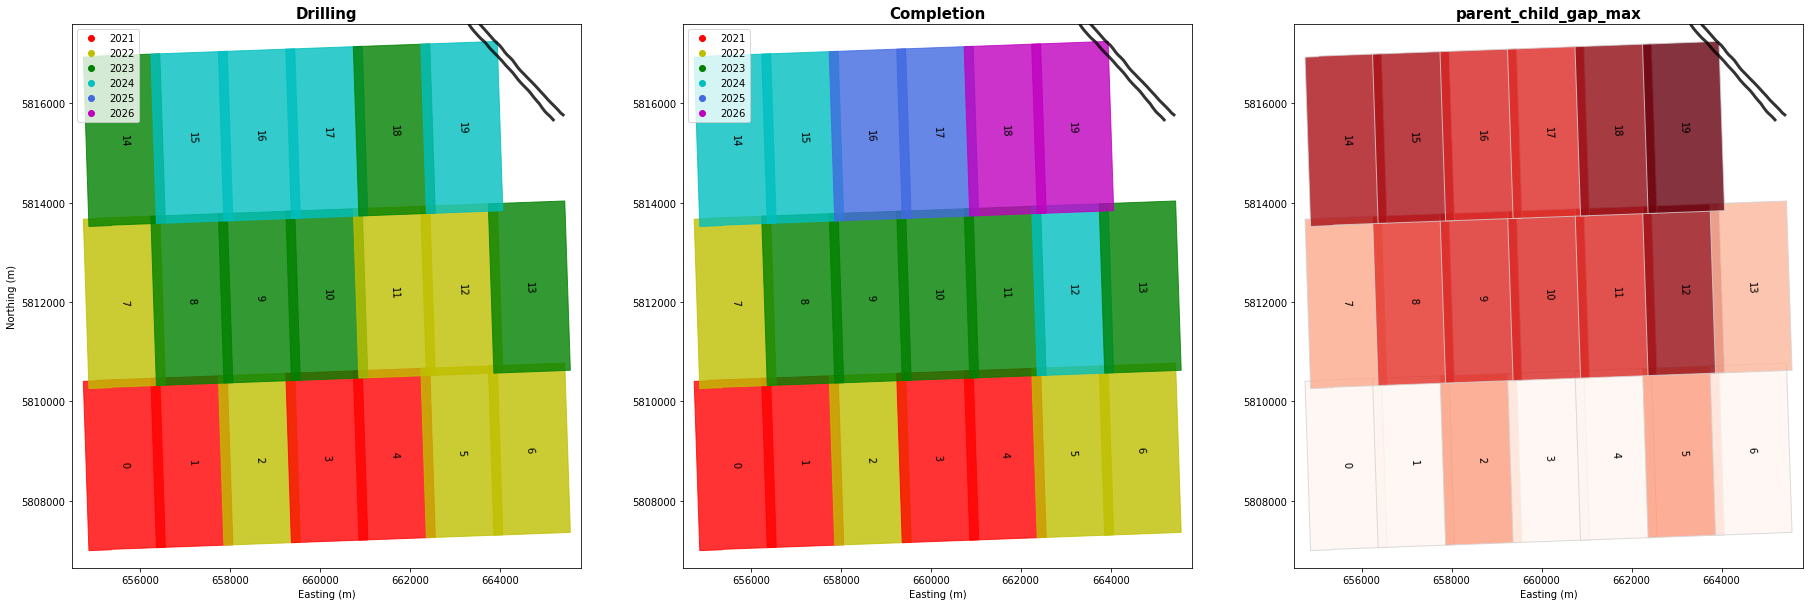

No handles with labels found to put in legend.




CPU times: user 3.73 s, sys: 24.7 ms, total: 3.75 s
Wall time: 3.8 s


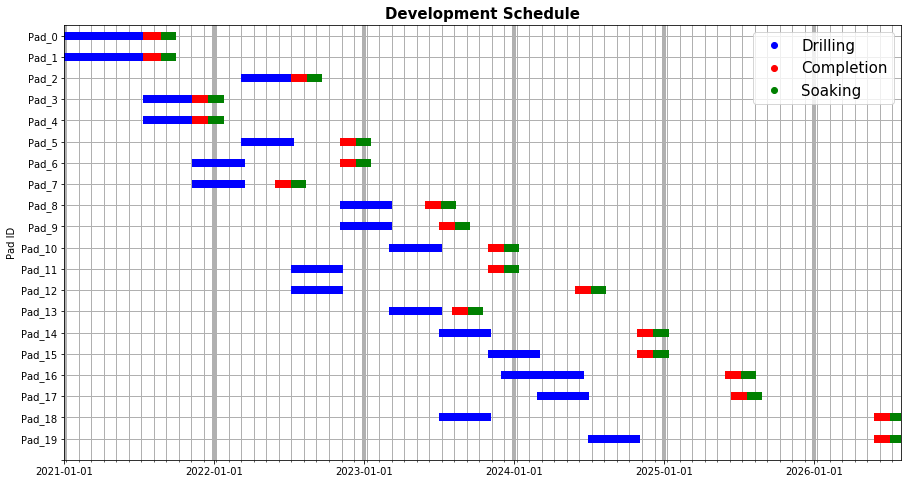

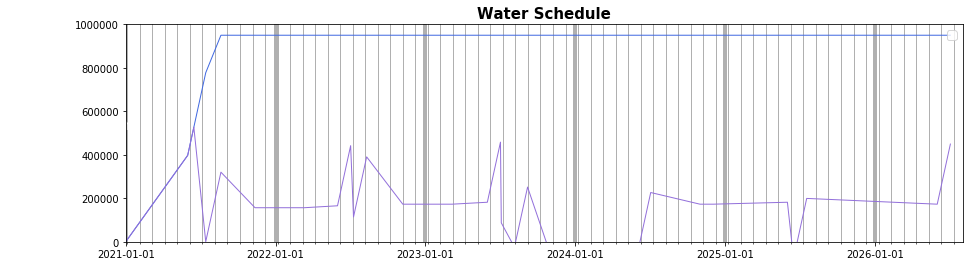

In [0]:
%%time
df = df_pad

#Shuffle second part of a dataframe. Uncommment the next 3 lines to run on shuffle mode.
# df_a = df[: index_shuffle]
# df_b = df[index_shuffle :].sample(frac=1)
# df = df_a.append(df_b).reset_index(drop=True)

#Calling main function 
pad_tracker, time_tracker = main(df)

#Plotting output
print(pad_tracker)
print()
print('Development schedule will take ', round((pad_tracker.compl_end.max() - dev_start).days / 365, 1), ' years')
print('The average parent-child gap is ', round(pad_tracker.parent_child_gap_max.mean(), 0), ' days')
print()
plot_dev_rectangles(pad_tracker, 'parent_child_gap_max')
print()
plot_schedule()
print()
plot_water()
print()

##SCHEDULER: Ordered Version

The PADs sequence can be pass as an input string. The sequence will be honoured unless a SIMOPS conflict arise.

        id drill_start   drill_end  ... compl_simops expired  fh_score
0    Pad_0  2021-01-01  2021-07-15  ...            0       5         0
1    Pad_1  2021-01-01  2021-07-15  ...            0       5         0
2    Pad_2  2022-03-12  2022-07-10  ...            0       5        36
3    Pad_3  2021-07-15  2021-11-12  ...            0       0        51
4    Pad_4  2021-07-15  2021-11-12  ...            0       0        32
5    Pad_5  2022-03-12  2022-07-10  ...            0       5        60
6    Pad_6  2021-11-12  2022-03-12  ...            0       0         0
7    Pad_7  2021-11-12  2022-03-12  ...            0       0        39
8    Pad_8  2022-11-07  2023-03-07  ...            0       5        24
9    Pad_9  2022-11-07  2023-03-07  ...            0       0         0
10  Pad_10  2023-03-07  2023-07-05  ...            0       5        60
11  Pad_11  2022-07-10  2022-11-07  ...            0       0         0
12  Pad_12  2022-07-10  2022-11-07  ...            0       5         0
13  Pa

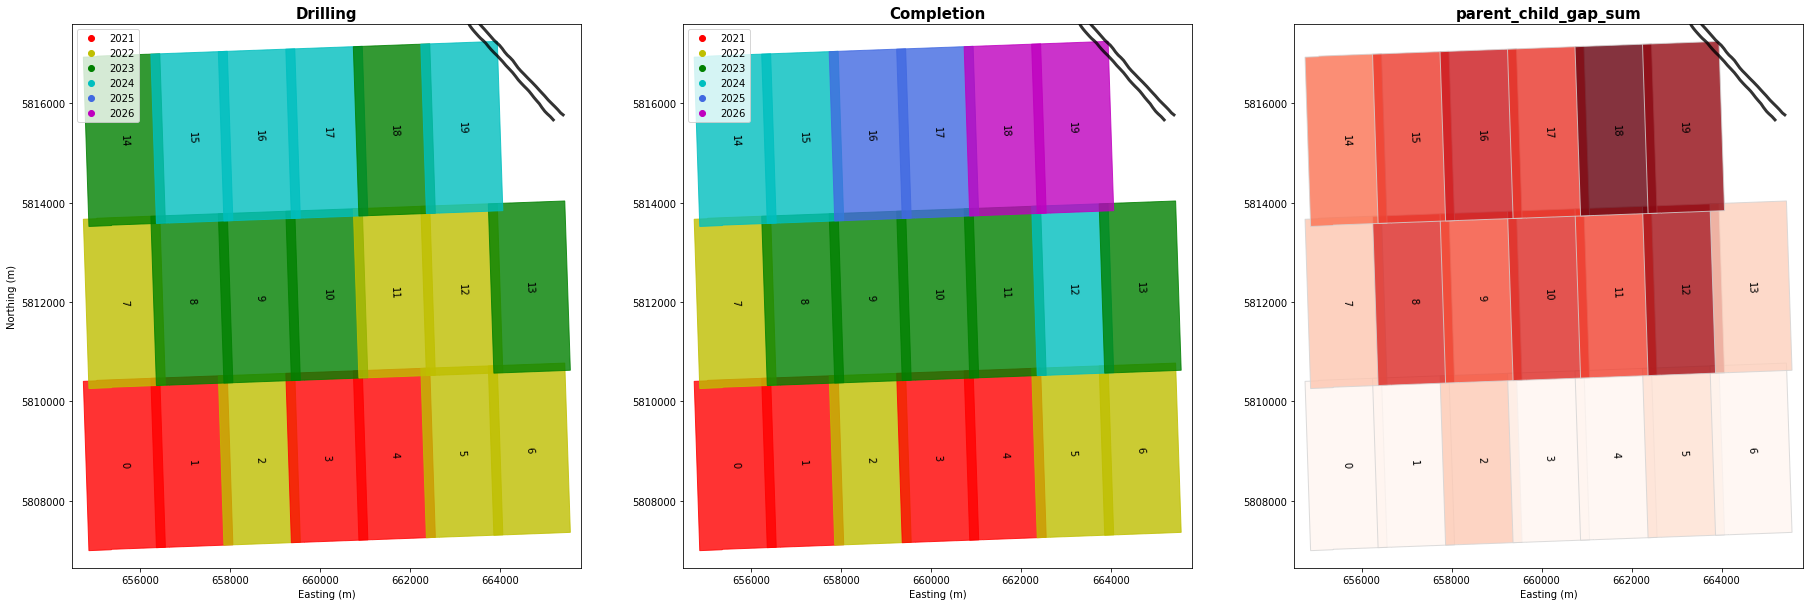

No handles with labels found to put in legend.


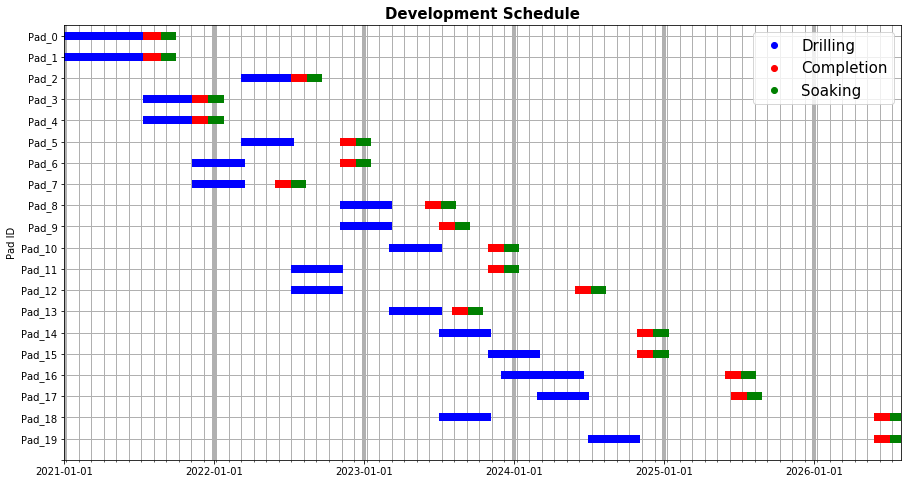

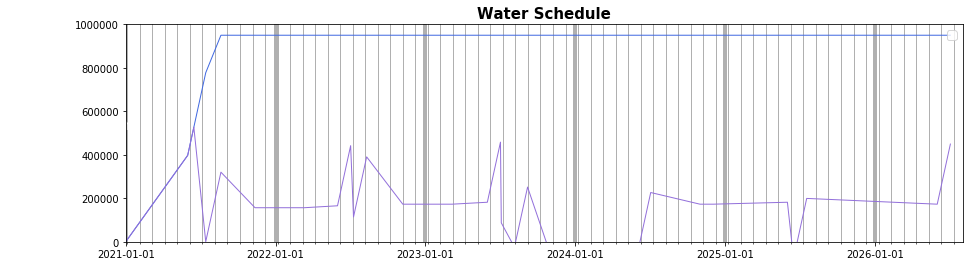

In [0]:
df = df_pad

ordered_list =['Pad_0',
 'Pad_1',
 'Pad_2',
 'Pad_3',
 'Pad_4',
 'Pad_5',
 'Pad_6',
 'Pad_7',
 'Pad_8',
 'Pad_9',
 'Pad_10',
 'Pad_11',
 'Pad_12',
 'Pad_13',
 'Pad_14',
 'Pad_15',
 'Pad_16',
 'Pad_17',
 'Pad_18',
 'Pad_19']

df_list = []
for i in ordered_list:
   df_list.append(df_pad[df_pad.id == i])
                         
df = pd.concat(df_list)

#Calling main function 
pad_tracker, time_tracker = main(df)

#Plotting output
print(pad_tracker)
print()
print('Development schedule will take ', round((pad_tracker.compl_end.max() - dev_start).days / 365, 1), ' years')
print('The average parent-child gap is ', round(pad_tracker.parent_child_gap_max.mean(), 0), ' days')
print()
plot_dev_rectangles(pad_tracker, 'parent_child_gap_sum')
print()
plot_schedule()
print()
plot_water()
print()

##OPTIMIZER: Ramdom Sampling

The SCHEDULER default version is used. The tail portion of the input sequence is shuffled. The "end" variable determined how many iterations are run. The "index_shuffle" in the parameters customization section determined which part of the sequence tail can be mixed and which part is locked. The soft contraint metrics tracked for each permutations are stored into the "scenario_tracker".

In [0]:
%%time
start = timeit.default_timer() #Start timer

#Set df
df = df_pad #create a copy (not a pointer)

#Instantiate Scenario_tracker
columns = ['order', 'duration', 'pc_sum_max', 'pc_sum_avg', 'pc_max_max', 'pc_max_avg', 'avg_ops_length', 'compl_simops', 'fh_score', 'expiry']
scenario_tracker = pd.DataFrame(columns=columns)

n = 0
end = 10

while n < end:
  #Shuffle second part of a dataframe.
  df_a = df[: index_shuffle]
  df_b = df[index_shuffle :].sample(frac=1)
  df = df_a.append(df_b).reset_index(drop=True)

  #Calling main function 
  pad_tracker, time_tracker = main(df)

  #Metrics
  data = {'order': [str(list(pad_tracker.id))],
        'duration': round((pad_tracker.compl_end.max() + soak_time - dev_start).days / 365, 2), #from last soak to dev start.
        'pc_sum_max': pad_tracker.parent_child_gap_sum.max(),
        'pc_sum_avg': int(pad_tracker.parent_child_gap_sum.mean()),
        'pc_max_max': pad_tracker.parent_child_gap_max.max(),
        'pc_max_avg': int(pad_tracker.parent_child_gap_max.mean()),
        'avg_ops_length': (pad_tracker.compl_end - pad_tracker.drill_start + soak_time).mean().days,
        'compl_simops': int(pad_tracker.compl_simops.sum()/2), #Division by 2 allows to track actual numbers or days that 2 crews were next to each others. This prevent double accounting.
        'fh_score': int(pad_tracker.fh_score.sum()),
        'expiry': int(pad_tracker.expired.sum())
       }
  
  scenario = pd.DataFrame(data, columns = columns)
  scenario_tracker = scenario_tracker.append(scenario)

  #Print Time Progress
  clear_output(wait=True)
  stop = timeit.default_timer() 
  if n < 2: #if less than 2 iterations went by
    expected_time = "Calculating..."
  else:
    expected_time = np.round(((stop - start) / (n / end))  / 60, 2)
  print("Current progress:", np.round(n / end * 100, 2), "%")
  print("Current Run Time:", np.round((stop - start) / 60, 2), "minutes")
  print("Expected Run Time:", expected_time, "minutes")
 
  n += 1
  
#Save result to csv
scenario_tracker.reset_index(drop=True).to_csv('scenario_tracker.csv') #Reset index before to save as csv
!cp scenario_tracker.csv /content/gdrive/My\ Drive/Colab\ Notebooks/Outputs
#Refresh the 'Files' tab, go under 'content' folder and right click for export to local drive.

Current progress: 90.0 %
Current Run Time: 0.37 minutes
Expected Run Time: 0.41 minutes
CPU times: user 22.1 s, sys: 37 ms, total: 22.1 s
Wall time: 23.5 s


In [0]:
from google.colab import drive
drive.mount('/content/drive')

##OPTIMIZER: Hill Climbing

The SCHEDULER: Ordered Version is used. Every pairs are swapped (1-2, 1-3, 1-4, 1-5 [...] 2-3, 2-4, 2-5 [...] 3-4, 3-5 [...]). It creates n(n-1) permutations where n is the number of PADs. The metrics tracked for each permutations are stored into the "scenario_tracker".

In [0]:
df = df_pad

ordered_list =['Pad_0',
 'Pad_1',
 'Pad_2',
 'Pad_3',
 'Pad_4',
 'Pad_5',
 'Pad_6',
 'Pad_7',
 'Pad_8',
 'Pad_9',
 'Pad_10',
 'Pad_11',
 'Pad_12',
 'Pad_13',
 'Pad_14',
 'Pad_15',
 'Pad_16',
 'Pad_17',
 'Pad_18',
 'Pad_19']

df_list = []
for i in ordered_list:
   df_list.append(df_pad[df_pad.id == i])
                         
df = pd.concat(df_list)


start = timeit.default_timer() #Start timer

#Instantiate Scenario_tracker
columns = ['order', 'duration', 'pc_sum_max', 'pc_sum_avg', 'pc_max_max', 'pc_max_avg', 'avg_ops_length', 'compl_simops', 'fh_score', 'expiry']
scenario_tracker = pd.DataFrame(columns=columns)

#Create a copy of df we can use to generate df after each shuffle
df_copy = df.copy()

n = 0
end = (df_pad.shape[0] - index_shuffle) * (df_pad.shape[0] - index_shuffle - 1)/2 #number of pair (n-1) divided by 2.

#Imbricated for loop allows to run the n*(n-1) pairs
for a in np.arange(index_shuffle, df_pad.shape[0] -1): 
  for b in np.arange(a + 1, df_pad.shape[0]):
    df = df_copy
    swap_a, swap_b = df.iloc[b].copy(), df.iloc[a].copy()
    df.iloc[b],df.iloc[a] = swap_b, swap_a
    
    #Calling main function 
    pad_tracker, time_tracker = main(df)

    #Metrics
    data = {'order': [str(list(pad_tracker.id))],
          'duration': round((pad_tracker.compl_end.max() + soak_time - dev_start).days / 365, 2), #from last soak to dev start.
          'pc_sum_max': pad_tracker.parent_child_gap_sum.max(),
          'pc_sum_avg': int(pad_tracker.parent_child_gap_sum.mean()),
          'pc_max_max': pad_tracker.parent_child_gap_max.max(),
          'pc_max_avg': int(pad_tracker.parent_child_gap_max.mean()),
          'avg_ops_length': (pad_tracker.compl_end - pad_tracker.drill_start + soak_time).mean().days,
          'compl_simops': int(pad_tracker.compl_simops.sum()/2), #Division by 2 allows to track actual numbers or days that 2 crews were next to each others. This prevent double accounting.
          'fh_score': int(pad_tracker.fh_score.sum()),
          'expiry': int(pad_tracker.expired.sum())
         }

    scenario = pd.DataFrame(data, columns = columns)
    scenario_tracker = scenario_tracker.append(scenario)

    #Print Time Progress
    clear_output(wait=True)
    stop = timeit.default_timer() 
    if n < 3: #if less than 2 iterations went by
      expected_time = "Calculating..."
    else:
      expected_time = np.round(((stop - start) / (n / end))  / 60, 2)
    print("Current progress:", np.round(n / end * 100, 2), "%")
    print("Current Run Time:", np.round((stop - start) / 60, 2), "minutes")
    print("Expected Run Time:", expected_time, "minutes")

    n += 1
  
#Save result to csv
scenario_tracker.reset_index(drop=True).to_csv('scenario_tracker.csv') #Reset index before to save as csv
!cp scenario_tracker.csv /content/gdrive/My\ Drive/Colab\ Notebooks/Outputs
#Refresh the 'Files' tab, go under 'content' folder and right click for export to local drive.
    